In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
fichier = open("raw_spectrum.txt", "r")

In [3]:
#fichier.read()
#for i in range(
x_data=[]
y_data=[]
n=[]
with open("spectrum.txt", "r") as filin:
    for ligne in filin:
        #print(ligne[:5])
        coords = ligne.split()
        x_data.append(float(coords[0]))
        y_data.append(float(coords[1]))
        n.append(np.sqrt(float(coords[1])))

In [4]:
#CrystalBall2 prend en argument une liste de valeurs de x
def CrystalBall2(x, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    for i in x:
        if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
            y = np.append(y, np.exp(-((i-mu)**2)/(2*sigma**2)))
        elif ((i-mu)/sigma < alpha):
            y = np.append(y, A*((B- (i -mu)/(sigma))**(-n)))
        elif((i-mu)/sigma > alphabis):
            y = np.append(y, C*((D+ (i -mu)/(sigma))**(-nbis)))
        else:
            y = np.append(y, 0.)
    return y*N

#CrystalBall2_2 prend en argument une valeur de x
def CrystalBall2_2(i, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
        y = np.exp(-((i-mu)**2)/(2*sigma**2))
    elif ((i-mu)/sigma < alpha):
        y = A*((B- (i -mu)/(sigma))**(-n))
    elif((i-mu)/sigma > alphabis):
        y = C*((D+ (i -mu)/(sigma))**(-nbis))
    return y*N

In [5]:
def NoiseVWG(x, mu, alpha, beta, N):
    y = np.array([], dtype=float)
    for i in x:
        sigma = alpha + beta*((i-mu)/mu)
        y = np.append(y, N * np.exp(-((i-mu)**2)/(2*sigma**2)))
    return y

In [6]:
def CB2withNoise(x, mu_CB2, sigma, N_CB2, mu_DE, alpha_DE, beta ,N_DE): #x est une liste
    alpha, alphabis, n, nbis=-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00
    #sigma = 6.10076777e-02
    return CrystalBall2(x, mu_CB2, sigma, alpha, alphabis, n, nbis, N_CB2) + NoiseVWG(x, mu_DE, alpha_DE, beta, N_DE)

def CB2withNoise_2(x, mu_CB2, sigma, N_CB2, mu_CB2_2, N_CB2_2, mu_DE, alpha_DE, beta ,N_DE): #x est une liste
    #alpha, alphabis, n, nbis=-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00
    alpha, alphabis, n, nbis =  -0.8203667286925543, 2.1288701493061883, 3.218068107049111, 2.3687325196482107 
    #alpha_2, alphabis2, n2, nbis2 = -3.22788197e+00, 2.37452148e+00, 1.82471094e+00, 1.31670260e+00
    alpha_2, alphabis2, n2, nbis2 = 0.8127277269512803, 2.140868246051813, 2.9612888277488696, 2.398926196259195
    #sigma = 6.10076777e-02
    return CrystalBall2(x, mu_CB2, sigma, alpha, alphabis, n, nbis, N_CB2) + CrystalBall2(x, mu_CB2_2, 1.05*sigma, alpha_2, alphabis2, n2, nbis2, N_CB2_2) + NoiseVWG(x, mu_DE, alpha_DE, beta, N_DE)

In [7]:
%time
popt_CB2wNoise, pcov_CB2wNoise = curve_fit(CB2withNoise_2, x_data, y_data, p0=[3.1, 0.07 , 10000., 3.68, 1000. , 6.29517373e-07 , 4.91666545e-01 , 1.19404276e-07 , 10000],
                    sigma=n, absolute_sigma = True,
                    bounds=([3., 0.01 , 0., 3.4, 0. , 0. , 0 , 0 , 0.],[3.2 , 0.1, np.inf, 3.7, np.inf , 0.00001 , 100. , 100. , np.inf]))

print(popt_CB2wNoise,pcov_CB2wNoise)
mu_fitCB2wNoise,sigma_fit,N_fitCB2wNoise,mu_fitCB2wNoise_2,N_fitCB2wNoise_2,mu_DE_fitCB2wNoise,alpha_DE_fitCB2wNoise,beta_fitCB2wNoise,N_DE_fitCB2wNoise = popt_CB2wNoise
#mu_fitCB2wNoise,sigma_fit,N_fitCB2wNoise,mu_fitCB2wNoise_2,N_fitCB2wNoise_2 mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise = popt_CB2wNoise
var_mu, var_sigma, var_N=pcov_CB2wNoise[0,0], pcov_CB2wNoise[1,1], pcov_CB2wNoise[2,2]
print('Variance de la masse du JPsi (mu CB2) :',var_mu)
print('Variance du sigma (sigma CB2) :',var_sigma)
print('Variance de l amplitude CB2 :',var_N)
y_data_fitCB2wNoise=CB2withNoise_2(x_data,mu_fitCB2wNoise,sigma_fit,N_fitCB2wNoise,mu_fitCB2wNoise_2,N_fitCB2wNoise_2, mu_DE_fitCB2wNoise, alpha_DE_fitCB2wNoise, beta_fitCB2wNoise, N_DE_fitCB2wNoise)

y_CB2_fit = CrystalBall2(x_data,mu_fitCB2wNoise, sigma_fit, -0.8203667286925543, 2.1288701493061883, 3.218068107049111, 2.3687325196482107,N_fitCB2wNoise)
y_CB2_fit_psi = CrystalBall2(x_data,mu_fitCB2wNoise_2, 1.05*sigma_fit, 0.8127277269512803, 2.140868246051813, 2.9612888277488696, 2.398926196259195,N_fitCB2wNoise_2)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs
[3.09176962e+00 6.42461536e-02 2.46780055e+04 3.70000000e+00
 1.59877447e+02 1.00000000e-05 5.96914253e-01 1.52762484e-06
 2.87015489e+05] [[ 4.84933114e-08 -1.94054274e-08  3.54924501e-03 -6.47033818e-08
  -3.19293340e-04 -1.13058119e-10 -1.86566043e-07 -1.66264832e-11
   9.91090562e-02]
 [-1.94054274e-08  5.06106852e-08 -1.05380386e-02  1.70913234e-07
   8.55304407e-04  3.46930029e-10  6.58719744e-07  5.08815175e-11
  -3.86443829e-01]
 [ 3.54924501e-03 -1.05380386e-02  5.98494562e+03  1.79420182e-02
   4.94098480e+01  1.06189179e-05  2.54856144e-02  1.55018473e-06
  -1.70668692e+04]
 [-6.47033818e-08  1.70913234e-07  1.79420182e-02  6.20595228e-05
   1.67695924e-01  8.66934721e-09  1.99623949e-05  1.26494617e-09
  -1.27935553e+01]
 [-3.19293340e-04  8.55304407e-04  4.94098480e+01  1.67695924e-01
   5.65616173e+02  3.76793785e-05  8.58871493e-02  5.49971480e-06
  -5.48813784e+04]
 [-1.13058119e-10  3.46930029e-10  1.06189

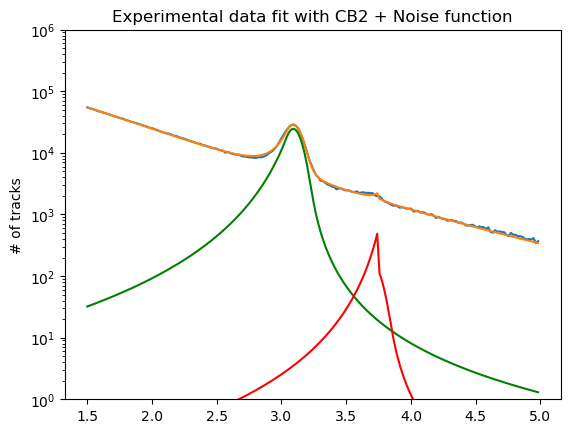

CPU times: user 1.89 s, sys: 72 ms, total: 1.96 s
Wall time: 2.02 s


In [8]:
%%time
#vhQualInvMassEvSel.plot(label="experimental data - events selected")
plt.plot(x_data,y_data)
plt.plot(x_data,y_data_fitCB2wNoise)
plt.plot(x_data,y_CB2_fit,'g')
plt.plot(x_data,y_CB2_fit_psi,'r')
plt.yscale("log")
plt.ylabel("# of tracks")
#plt.legend()
plt.title('Experimental data fit with CB2 + Noise function')
plt.ylim(1,1000000)
plt.show()

In [9]:
width=200
y_data_finale=[]
for i in x_data:
    y_data_finale.append(CrystalBall2_2(i, mu_fitCB2wNoise, sigma_fit,-0.8203667286925543, 2.1288701493061883, 3.218068107049111, 2.3687325196482107,N_fitCB2wNoise))

I = quad(CrystalBall2_2,1,5,
        args=(mu_fitCB2wNoise, sigma_fit,-0.8203667286925543, 2.1288701493061883, 3.218068107049111, 2.3687325196482107,N_fitCB2wNoise))
I = I[0] /0.175
print('Valeur de l intégrale en utilisant la fonction quad de scipy',I)

Valeur de l intégrale en utilisant la fonction quad de scipy 29839.000700236433


In [10]:
var_alpha,var_alpha1,var_n,var_n1 = 3.82025732e-04,1.74935625e-02,2.11990082e-01,1.42526094e-01

# définir le point où l'on veut calculer la dérivée partielle
point = [mu_fitCB2wNoise, sigma_fit,-7.16686241e-01,2.28952917e+00,4.41736692e+00,2.61183775e+00,N_fitCB2wNoise]

# définir la précision pour les calculs numériques
eps = 1e-10

# calculer la dérivée partielle par rapport à mu
d_mu = (CrystalBall2(x_data,point[0] + eps, point[1], point[2], point[3], point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_mu = var_mu * d_mu

# calculer la dérivée partielle par rapport à sigma
d_sigma = (CrystalBall2(x_data,point[0], point[1] + eps, point[2], point[3], point[4], point[5], point[6]) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_sigma = var_sigma*d_sigma

# calculer la dérivée partielle par rapport à alpha
d_N = (CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6]+eps) - CrystalBall2(x_data,point[0], point[1], point[2], point[3], point[4], point[5], point[6])) / eps
d_N = np.abs(var_N*d_N)

# liste des listes des dérivées
#d_list=[d_mu, d_sigma, d_alpha, d_alpha1, d_n, d_n1]
d_list_stat=[d_mu, d_sigma, d_N]

pas=x_data[1]-x_data[0]
integrale_list1 = []
for i in range(0,len(d_list_stat)):
    a=0
    for j in d_list_stat[i]:
        a = a + j*pas
    integrale_list1.append(a/0.175)
print(integrale_list1)

uncertainty_stat_NJPsi = sum(integrale_list1)
print("Nombre J/Psi :", I)
print("Incertitude statistique sur le nombre de J/Psi :", uncertainty_stat_NJPsi)
print(uncertainty_stat_NJPsi/I)

[0.00013606806379144162, 0.023983482506439474, 7198.291739905389]
Nombre J/Psi : 29839.000700236433
Incertitude statistique sur le nombre de J/Psi : 7198.315859455959
0.2412385029837451
